# Stochastic Model 02: Algoritmus MCMC (Metropolis–Hastings)

In [1]:
# Instalace potřebných knihoven
#%pip install pandas
#%pip install numpy
#%pip install seaborn matplotlib

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### Načtení přechodové matice

In [3]:
# Soubor je načten a přiřazen do proměnné ‚df‘
other_path = '../../data/03_StochModel/transition_matrix.csv'
df = pd.read_csv(other_path, header=0)
P = df.to_numpy()
P

array([[6.05743947e-01, 3.93469340e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.49539215e-04, 0.00000000e+00, 3.37173360e-04, 0.00000000e+00],
       [0.00000000e+00, 6.05743947e-01, 3.93469340e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.49539215e-04, 0.00000000e+00, 3.37173360e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.17157480e-01, 1.81269247e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.49539215e-04, 7.86561002e-04, 3.37173360e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.05743947e-01,
        3.93469340e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.49539215e-04, 0.00000000e+00, 3.37173360e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.15697216e-01, 1.81269247e-01, 0.00000000e+00, 0.00

### Výpočet stacionárního rozdělení

In [4]:
eigvals, eigvecs = np.linalg.eig(P.T)
idx = np.argmin(np.abs(eigvals-1))
pi = np.real(eigvecs[:,idx])
pi = pi / np.sum(pi)

### Parametry simulace

In [5]:
n_states = 12

# počet iteračních kroků (sekund)
n_iter = 100_000

# směrodatná odchylka návrhového normálního rozdělení
sigma = 1.5

samples = np.zeros(n_iter, dtype=int)

# počáteční stav S1 (index 0)
current_state = 0
samples[0] = current_state

# nastavení seedu (počátečního stavu generátoru náhodných čísel)
np.random.seed(122)

### Metropolis–Hastings simulace

In [6]:
for t in range(1, n_iter):

    # --- návrh nového stavu ---
    proposal = int(np.round(
        np.random.normal(loc=current_state, scale=sigma)
    ))

    # omezení na interval stavů
    proposal = np.clip(proposal, 0, n_states-1)

    # --- pravděpodobnosti ---
    p_current = pi[current_state]
    p_proposal = pi[proposal]

    # symetrické návrhové rozdělení → zkrácení poměru
    alpha = min(1, p_proposal / p_current)

    # --- přijetí / zamítnutí ---
    if np.random.rand() < alpha:
        current_state = proposal

    samples[t] = current_state

### Výsledná trajektorie stavů

In [7]:
# převod na stavy S1–S12
states = samples + 1

### Empirické rozdělení

In [8]:
hist = np.bincount(samples, minlength=n_states)
empirical_pi = hist / np.sum(hist)

print("Empirické rozdělení:")
print(empirical_pi)

Empirické rozdělení:
[0.08948 0.05646 0.13601 0.06233 0.13584 0.18241 0.08404 0.15545 0.02463
 0.02046 0.04638 0.00651]


### Porovnání se stacionárním rozdělením

In [9]:
print("Teoretické pi:")
print(pi)

Teoretické pi:
[0.0640775  0.06394964 0.13918257 0.06399273 0.13770963 0.18641433
 0.0870604  0.15993584 0.02454114 0.02018244 0.04883054 0.00412323]


### Sloupcový density graf

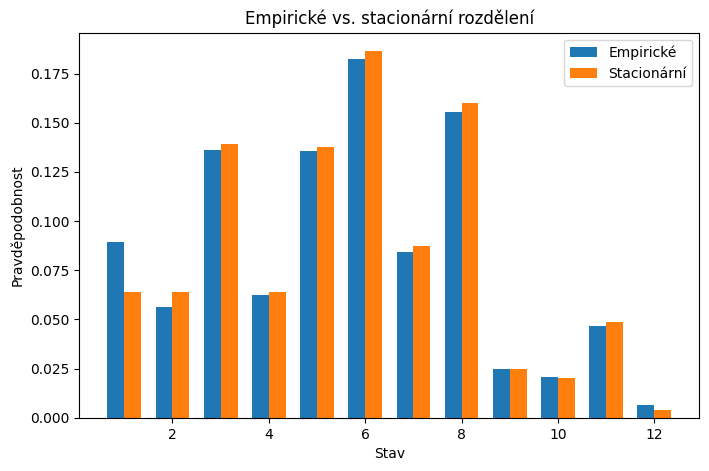

In [10]:
width = 0.35
states = np.arange(1,13)
plt.figure(figsize=(8,5))

plt.bar(states - width/2, empirical_pi, width, label='Empirické')
plt.bar(states + width/2, pi, width, label='Stacionární')

plt.xlabel("Stav")
plt.ylabel("Pravděpodobnost")
plt.title("Empirické vs. stacionární rozdělení")
plt.legend()
plt.show()

### Ilustrační graf simulace

In [11]:
time = np.arange(len(samples))
states = samples + 1   # převod na S1–S12

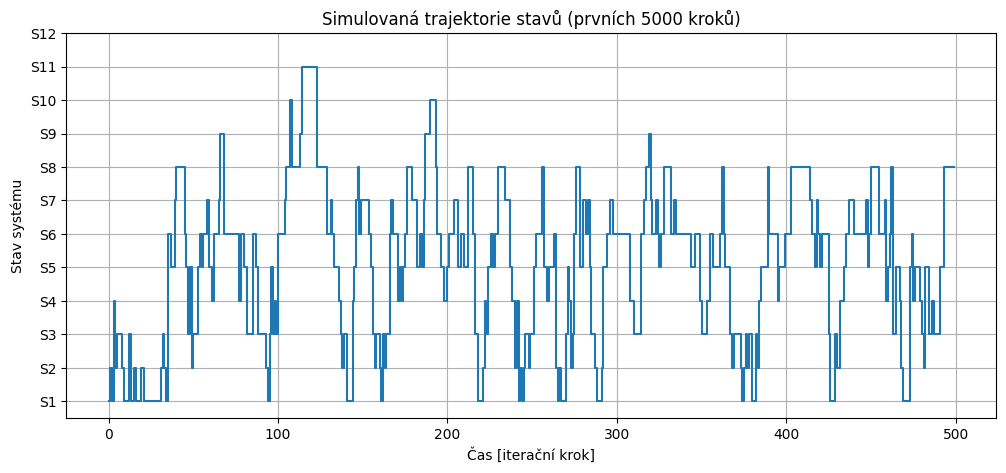

In [12]:
N = 500

plt.figure(figsize=(12,5))
plt.step(time[:N], states[:N], where='post')

plt.xlabel("Čas [iterační krok]")
plt.ylabel("Stav systému")
plt.title("Simulovaná trajektorie stavů (prvních 5000 kroků)")

plt.yticks(np.arange(1,13), [f"S{i}" for i in range(1,13)])
plt.grid(True)

plt.show()

### Spálení počáteční části simulace (Burn-in)

Počáteční transientní fáze simulace (burn-in) byla identifikována a odstraněna z další analýzy. Tato oblast je v grafu vyznačena červeně.

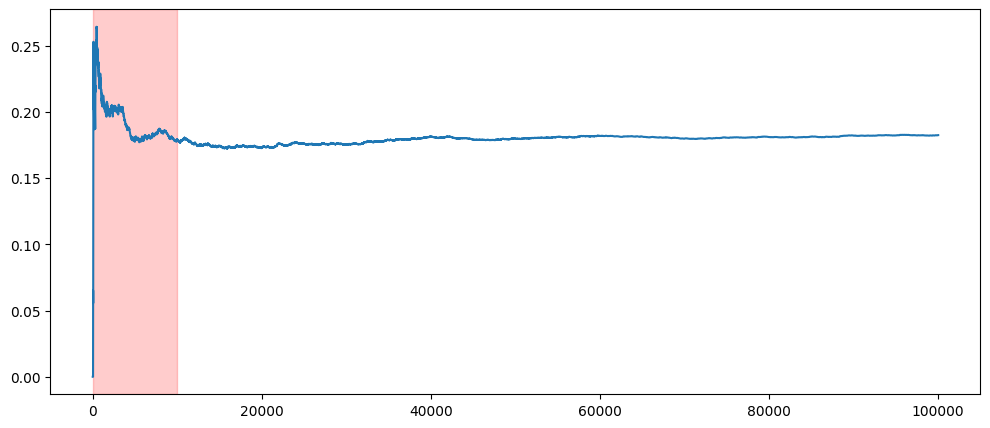

In [13]:
burn_in = 10_000
running_mean = np.cumsum(samples==5)/np.arange(1,len(samples)+1)
plt.figure(figsize=(12,5))
plt.axvspan(0, burn_in, color='red', alpha=0.2, label='Burn-in')
plt.plot(running_mean)

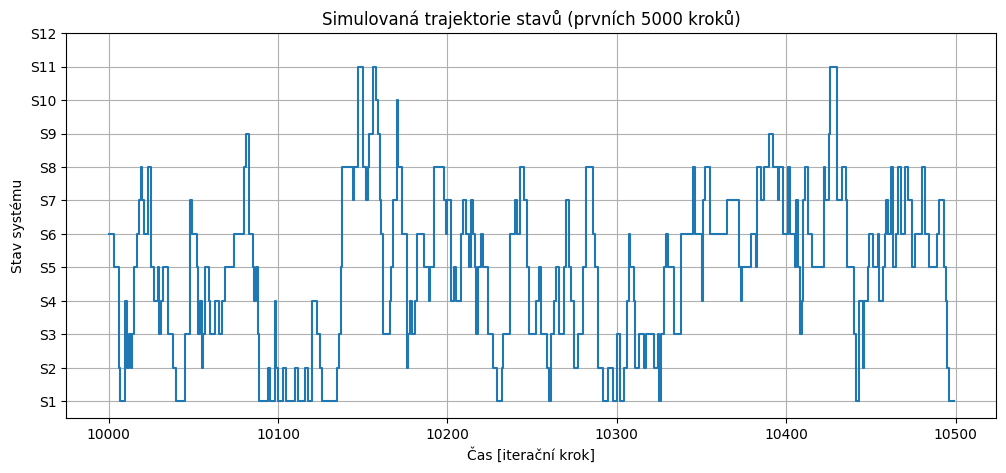

In [14]:

plt.figure(figsize=(12,5))
plt.step(time[burn_in:burn_in+N], states[burn_in:burn_in+N], where='post')

plt.xlabel("Čas [iterační krok]")
plt.ylabel("Stav systému")
plt.title("Simulovaná trajektorie stavů (prvních 5000 kroků)")

plt.yticks(np.arange(1,13), [f"S{i}" for i in range(1,13)])
plt.grid(True)

plt.show()

### Odstranění burn-in

In [15]:
samples_burned = samples[burn_in:]

### Empirické rozdělení

In [16]:
hist = np.bincount(samples_burned, minlength=n_states)
empirical_pi = hist / np.sum(hist)

print("Empirické rozdělení:")
print(empirical_pi)

Empirické rozdělení:
[0.09033333 0.05648889 0.1359     0.06225556 0.13518889 0.18282222
 0.08408889 0.15475556 0.02436667 0.02058889 0.04686667 0.00634444]


### Porovnání se stacionárním rozdělením

In [17]:
print("Teoretické pi:")
print(pi)

Teoretické pi:
[0.0640775  0.06394964 0.13918257 0.06399273 0.13770963 0.18641433
 0.0870604  0.15993584 0.02454114 0.02018244 0.04883054 0.00412323]


### Sloupcový density graf

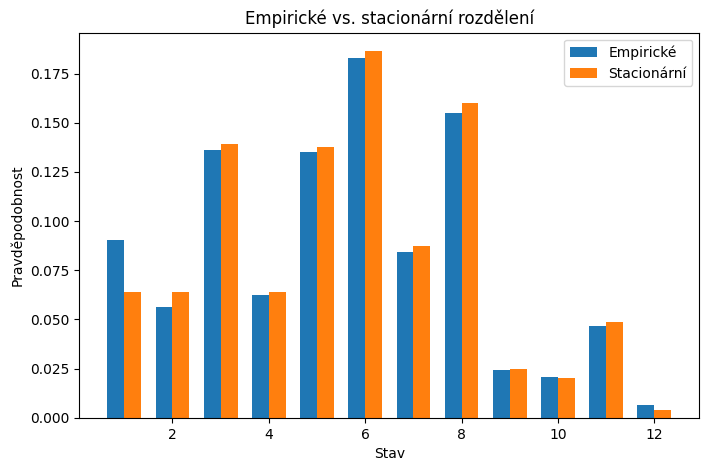

In [18]:
width = 0.35
states = np.arange(1,13)
plt.figure(figsize=(8,5))

plt.bar(states - width/2, empirical_pi, width, label='Empirické')
plt.bar(states + width/2, pi, width, label='Stacionární')

plt.xlabel("Stav")
plt.ylabel("Pravděpodobnost")
plt.title("Empirické vs. stacionární rozdělení")
plt.legend()
plt.show()

### Export simulace formátu CSV

In [19]:
df_sim = pd.DataFrame({
    "time": np.arange(len(samples_burned)),
    "state_index": samples_burned,
    "state": samples_burned + 1
})

In [20]:
df_sim.to_csv('../../data/03_StochModel/simulation_MCMC_MH.csv', index=False)

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-01-25 | 1.1 | Vjačeslav Usmanov| added SM_02_MCMC_MH.ipynb |
| 2026-02-15 | 1.2 | Vjačeslav Usmanov| changed SM_02_MCMC_MH.ipynb |